<a href="https://colab.research.google.com/github/mobarakol/nnUNet_BraTS/blob/master/nnUNet_brats23_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Data and Weights

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=1DqewqWGTY7KyLuCz_sEi6l3Q59Sz8PEr'
gdown.download(url,'epoch=173-dice=90.28.ckpt',quiet=True)

url = 'https://drive.google.com/uc?id=1KDmrqD8EV7ElSiOgZS5p8uHRHxwwnK4n'
gdown.download(url,'epoch=131-dice=90.34.ckpt',quiet=True)

url = 'https://drive.google.com/uc?id=19iCnCxhdLa2LcudMYf6r97HGgsa7LRvl'
gdown.download(url,'epoch=195-dice=91.42.ckpt',quiet=True)

# url = 'https://drive.google.com/uc?id=13mf4PB-6p1lu43JuT6KO5wj7Pgkmtad6'
# gdown.download(url,'epoch=166-dice=90.83.ckpt',quiet=True)

# url = 'https://drive.google.com/uc?id=1Y0tDcGGgwcSEtmOFW5hYZeDL1IMhNmOZ'
# gdown.download(url,'epoch=72-dice=89.73.ckpt',quiet=True)

url = 'https://drive.google.com/uc?id=1dZDw0wFDTIZlAbFEqSAfMaKOAlEG_Fat'
gdown.download(url,'ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData.zip',quiet=True)
!unzip -q ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData.zip
!mv ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData official_valid

In [2]:
url = 'https://drive.google.com/uc?id=13mf4PB-6p1lu43JuT6KO5wj7Pgkmtad6'
gdown.download(url,'epoch=166-dice=90.83.ckpt',quiet=True)

'epoch=166-dice=90.83.ckpt'

Download Code

In [3]:
# !git clone https://github.com/NVIDIA/DeepLearningExamples.git
!git clone https://github.com/mobarakol/nnUNet_BraTS.git
%cd nnUNet_BraTS

Cloning into 'nnUNet_BraTS'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 129 (delta 53), reused 57 (delta 13), pack-reused 0
Receiving objects: 100% (129/129), 499.83 KiB | 5.62 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/nnUNet_BraTS


Required installation:

In [4]:
!pip -q install monai pytorch-lightning git+https://github.com/NVIDIA/dllogger git+https://github.com/NVIDIA/mlperf-common.git -U rich
#check nvidia-smi for nvidia version
#if nvidia version is 12.++ then use below command
!pip -q install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda120

#if nvidia version is 11.++ then use below command
# !pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 3.5 MB/s eta 0:00:00


#Data pre-processing
Create 2 folders 1 file:<br>
Folder1 = images: stack 4 input MRIs into one (240, 240, 155, 4) for each case <br>
Fodler2 = labels: split the seg mask into this folder for each case<br>
file = dataset.jason: mapped each image and corresponding label, mapped label names

In [5]:
import json
import os
from glob import glob
from subprocess import call
import time

import nibabel
import numpy as np
from joblib import Parallel, delayed


def load_nifty(directory, example_id, suffix):
    return nibabel.load(os.path.join(directory, example_id + "-" + suffix + ".nii.gz"))


def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["t2f", "t1n", "t1c", "t2w"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)


def prepare_nifty(d):
    example_id = d.split("/")[-1]
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
    nibabel.save(vol, os.path.join(d, example_id + ".nii.gz"))

    if os.path.exists(os.path.join(d, example_id + "-seg.nii.gz")):
        seg = load_nifty(d, example_id, "seg")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
        vol[vol == 4] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
        nibabel.save(seg, os.path.join(d, example_id + "-seg.nii.gz"))


def prepare_dirs(data, train):
    img_path, lbl_path = os.path.join(data, "images"), os.path.join(data, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(data, "BraTS*"))
    for d in dirs:
        if "-" in d.split("/")[-1]:
            files = glob(os.path.join(d, "*.nii.gz"))
            for f in files:
                if "t2f" in f or "t1n" in f or "t1c" in f or "t2w" in f:
                    continue
                if "-seg" in f:
                    call(f"mv {f} {lbl_path}", shell=True)
                else:
                    call(f"mv {f} {img_path}", shell=True)
        call(f"rm -rf {d}", shell=True)


def prepare_dataset_json(data, train=True):
    images, labels = glob(os.path.join(data, "images", "*")), glob(os.path.join(data, "labels", "*"))
    images = sorted([img.replace(data + "/", "") for img in images])
    labels = sorted([lbl.replace(data + "/", "") for lbl in labels])

    modality = {"0": "t2f", "1": "t1n", "2": "t1c", "3": "t2w"}
    labels_dict = {"0": "background", "1": "edema", "2": "non-enhancing tumor", "3": "enhancing tumour"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(data, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train):
    print(f"Preparing BraTS23 dataset from: {data}")
    start = time.time()
    run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "BraTS*"))))
    prepare_dirs(data, train)
    prepare_dataset_json(data, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")

# prepare_dataset("/content/train_valid", train=True)
prepare_dataset("/content/official_valid", train=False)
print("Finished!")

Preparing BraTS23 dataset from: /content/official_valid
Preparing time: 134.19
Finished!


Cropping and normalizing the volumes:<br>
1. crop the background padding (with voxel value zero)<br>
2. compute mean and the standard deviation  within the non-zero region for each channel separately<br>
3. The background voxels are not normalized so that their value remained at zero

Cropping and Normalizing:
1. Transpose stacked volume in to pytorch format [B x C x D x H x W] <br>
1. Creating a folder with name 11_3d and store 4 normalized files for each case:<br>
(i) _x.npy (): To distinguish between background voxels and normalized voxels which have values close to zero, we add an input channel with one-hot encoding for foreground voxels and stacked with the input data. As a result, each example has 5 channels.<br>
(ii) _y.npy(): Cropped label which is same as _orig_lbl.npy()<br>
(iii) _orig_lbl.npy(): cropped original label<br>
(iv) _meta.npy(): cropping information with 4 coordinates:[[zmin, xmin, ymin], [zmax, xmax, ymax],[z, x, y],[zcrop, xcrop, ycrop]<br>
2. config.pkl: a dictionary with the information of patch size, channel and classes like<br>
{'patch_size': [128, 128, 128], 'spacings': [1.0, 1.0, 1.0], 'n_class': 4 'in_channels': 5}


In [6]:
# If there is any error with MKL then run the first command then restart the notebook then run the both commands
# !export MKL_SERVICE_FORCE_INTEL=1
!python3 preprocess.py --task 12 --ohe --exec_mode test --data /content --results /content/official_valid

2023-08-16 12:43:50.373881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 12:43:51.944098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Preprocessing /content/official_valid
2023-08-16 12:44:06.437624: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-16 12:44:06.560896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-16 12:44:06.799532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-16 12:44:07.222277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Pre-processing time: 268.90


visualization after normalised and cropped

_x: (5, 137, 190, 140) _meta: (4, 3)
{'patch_size': [128, 128, 128], 'spacings': [1.0, 1.0, 1.0], 'n_class': 4, 'in_channels': 5}


Text(0.5, 1.0, '_x[4]:oh_fg')

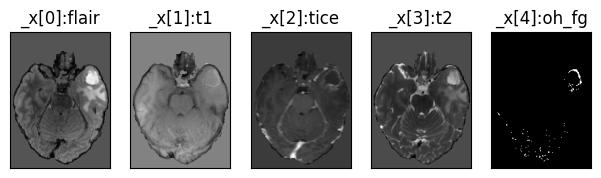

In [7]:
import matplotlib.pyplot as plt
_x = np.load('/content/official_valid/12_3d/test/BraTS-GLI-00001-000_x.npy')
_meta = np.load('/content/official_valid/12_3d/test/BraTS-GLI-00001-000_meta.npy')
print('_x:',_x.shape,'_meta:', _meta.shape)

import pickle
with open('/content/official_valid/12_3d/test/config.pkl', 'rb') as f:
    data = pickle.load(f)
print(data)

num_img = 5
slice_n = 40
fig, ax = plt.subplots(1, num_img, figsize=(1.5*num_img,7), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(_x[0,slice_n,], cmap='gray')
ax[0].set_title('_x[0]:flair')
ax[1].imshow(_x[1,slice_n,], cmap='gray')
ax[1].set_title('_x[1]:t1')
ax[2].imshow(_x[2,slice_n,], cmap='gray')
ax[2].set_title('_x[2]:tice')
ax[3].imshow(_x[3,slice_n,], cmap='gray')
ax[3].set_title('_x[3]:t2')
ax[4].imshow(_x[4,slice_n,], cmap='gray')
ax[4].set_title('_x[4]:oh_fg')


Prediction on Fold0

In [ ]:
!python main.py --brats --deep_supervision --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --gpus 1 --amp --save_preds --exec_mode predict  --data /content/official_valid/12_3d/test --ckpt_path /content/epoch=131-dice=90.34.ckpt --tta --results /content/official_valid
!python main.py --brats --deep_supervision --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --gpus 1 --amp --save_preds --exec_mode predict  --data /content/official_valid/12_3d/test --ckpt_path /content/epoch=173-dice=90.28.ckpt --tta --results /content/official_valid
!python main.py --brats --deep_supervision --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --gpus 1 --amp --save_preds --exec_mode predict  --data /content/official_valid/12_3d/test --ckpt_path /content/epoch=195-dice=91.42.ckpt --tta --results /content/official_valid
# !python main.py --brats --deep_supervision --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --gpus 1 --amp --save_preds --exec_mode predict  --data /content/official_valid/12_3d/test --ckpt_path /content/epoch=166-dice=90.83.ckpt --tta --results /content/official_valid
# !python main.py --brats --deep_supervision --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --gpus 1 --amp --save_preds --exec_mode predict  --data /content/official_valid/12_3d/test --ckpt_path /content/epoch=72-dice=89.73.ckpt --tta --results /content/official_valid

2023-08-16 12:48:36.445189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 12:48:37.893134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
0 training, 0 validation, 219 test examples
Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../epoch=131-dice=90.34.ckpt`
Filters: [64, 96, 128, 192, 256, 384, 512],
Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: U

Post-processing

In [ ]:
import os
from glob import glob
from subprocess import call

import nibabel as nib
import numpy as np
from scipy.ndimage.measurements import label


def to_lbl(pred):
    enh = pred[2]
    c1, c2, c3 = pred[0] > 0.4, pred[1] > 0.35, pred[2] > 0.375
    pred = (c1 > 0).astype(np.uint8)
    pred[(c2 == False) * (c1 == True)] = 2
    pred[(c3 == True) * (c1 == True)] = 4

    components, n = label(pred == 4)
    for et_idx in range(1, n + 1):
        _, counts = np.unique(pred[components == et_idx], return_counts=True)
        if 1 < counts[0] and counts[0] < 4 and np.mean(enh[components == et_idx]) < 0.9:
            pred[components == et_idx] = 1

    et = pred == 4
    if 0 < et.sum() and et.sum() < 5 and np.mean(enh[et]) < 0.9:
        pred[et] = 1

    pred[pred==4] = 3
    pred = np.transpose(pred, (2, 1, 0)).astype(np.uint8)
    return pred


def prepare_preditions(e):
    fname = e[0].split("/")[-1].split(".")[0]
    preds = [np.load(f) for f in e]
    p = to_lbl(np.mean(preds, 0))
    # print(f"/content/official_valid/images/{fname}.nii.gz")
    img = nib.load(f"/content/official_valid/images/{fname}.nii.gz")
    img1 = img.get_fdata()[:,:,:,0]
    p[img1==0] = 0
    nib.save(
        nib.Nifti1Image(p, img.affine, header=img.header),
        os.path.join("final_preds", fname + ".nii.gz"),
    )

os.makedirs("final_preds", exist_ok=True )
preds = sorted(glob(f"/content/official_valid/predictions*"))
examples = list(zip(*[sorted(glob(f"{p}/*.npy")) for p in preds]))
print("Preparing final predictions")
for e in examples:
    prepare_preditions(e)
print("Finished!")

Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 1, 75
data = sorted(glob("final_preds/*.nii.gz"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/content/official_valid/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    pred = nib.load(data[i]).get_fdata().astype(np.uint8)[:, :, z]
    imgs = [img[:, :, z, i] for i in [0, 3]] + [pred]

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    for i in range(3):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
!zip -r final_preds.zip final_preds

In [ ]:
from google.colab import files
files.download('final_preds.zip')